# Optimized Portfolio Optimization in Python with AMPL using EIA Data
[![Notebook_1_Portfolio_Optimization_Commodities.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_1_Portfolio_Optimization_Commodities.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_1_Portfolio_Optimization_Commodities.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_1_Portfolio_Optimization_Commodities.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_1_Portfolio_Optimization_Commodities.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_1_Portfolio_Optimization_Commodities.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_1_Portfolio_Optimization_Commodities.ipynb)](https://colab.ampl.com)

Description: Portfolio Optimization across Crude Oil, Gold, Natural Gas, Silver, and the S&P 500.

Tags: finance, portfolio-optimization, mean-variance

Notebook author: Mukeshwaran Baskaran <<mukesh96official@gmail.com>>

### **What the Code Does:**
This code is a **portfolio optimization tool** that helps you decide how to invest in different assets (like Crude Oil, Gold, Natural Gas, Silver, and the S&P 500) to achieve specific financial goals. It uses historical data and advanced math to find the best way to distribute your money across these assets.

---

### **Steps in the Code:**

1. **Install Required Tools:**
   - The code installs necessary Python libraries like `amplpy` (for optimization) and `yfinance` (to get financial data).

2. **Import Libraries:**
   - It imports tools for data analysis (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), and fetching data (`yfinance`, `requests`).

3. **Enter API Key:**
   - It asks for the API key to be used to fetch data from the **[EIA (Energy Information Administration)](https://www.eia.gov/opendata/)** regarding crude oil inventories.

4. **Define Assets and Time Period:**
   - The code focuses on 5 assets: Crude Oil, Gold, Natural Gas, Silver, and the S&P 500 (SPY).
   - It sets a time period (from January 1, 2020, to January 1, 2025) to analyze historical data.

5. **Fetch Data:**
   - **Crude Oil Inventories:** It fetches weekly crude oil inventory data from the EIA API.
   - **Commodity Prices:** It downloads historical price data for the 5 assets using `yfinance`.

6. **Calculate Statistics:**
   - It calculates:
     - **Daily Returns:** How much the price of each asset changes daily.
     - **Covariance Matrix:** How the assets move in relation to each other.
     - **Mean Returns:** The average daily return for each asset.

7. **Initialize AMPL:**
   - AMPL is a tool for solving optimization problems. The code sets it up with specific modules and a license.

8. **Define Optimization Functions:**
   - The code defines three types of portfolio optimization:
     - **Mean-Variance Optimization:** Finds the portfolio with the lowest risk for a given level of return.
     - **Risk Parity Optimization:** Balances risk equally across all assets.
     - **Maximum Sharpe Ratio Optimization:** Finds the portfolio with the best risk-adjusted return.

9. **Plot Results:**
   - It creates **pie charts** to visualize how much money should be invested in each asset based on the optimization results.

10. **Run Optimizations:**
    - It runs each optimization (Mean-Variance, Risk Parity, and Maximum Sharpe Ratio) and displays the results as pie charts.

---

### **Outputs:**
- **Mean-Variance Portfolio:** A pie chart showing how to distribute investments to minimize risk.
- **Risk Parity Portfolio:** A pie chart showing how to balance risk equally across assets.
- **Maximum Sharpe Ratio Portfolio:** A pie chart showing how to maximize returns relative to risk.


In [76]:
# Install dependencies
%pip install amplpy yfinance matplotlib seaborn pandas numpy requests -q

In [77]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Prompt for EIA API key

You need to provide the API key to be used to fetch data from the **[EIA (Energy Information Administration)](https://www.eia.gov/opendata/)** regarding crude oil inventories.

In [78]:
import os
from getpass import getpass

if os.environ.get("EIA_API_KEY", "") == "":
    # Prompt the user to enter their API key securely
    os.environ["EIA_API_KEY"] = getpass("Enter your EIA API key: ")
    print("API Key stored successfully!")
else:
    print("API Key already stored!")

API Key already stored!


## Implementation

### Import libraries

In [79]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

### Define constants

In [80]:
# Define commodities and fetch data
COMMODITIES = [
    "CL=F",
    "GC=F",
    "NG=F",
    "SI=F",
    "SPY",
]  # Crude Oil, Gold, Natural Gas, Silver, SPY,

START_DATE = "2020-01-01"
END_DATE = "2025-01-01"

### Fetch crude oil inventories from EIA API

In [81]:
def fetch_crude_inventories(api_key):
    """Fetch crude oil inventories data from EIA API."""
    base_url = "https://api.eia.gov/v2/petroleum/stoc/wstk/data/"
    params = {
        "frequency": "weekly",
        "data[0]": "value",
        "facets[series][]": "WTTSTUS1",
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": 0,
        "length": 5000,
        "api_key": api_key,
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data["response"]["data"])
        df["period"] = pd.to_datetime(df["period"])
        df.set_index("period", inplace=True)
        return df[["value"]].rename(columns={"value": "Inventories"})
    else:
        raise Exception(f"Failed to fetch data: {response.status_code}")

### Download historical data for commodities

In [82]:
def fetch_commodities_data(tickers, start_date, end_date):
    """Fetch historical data for given tickers."""
    data = yf.download(tickers, start=start_date, end=end_date)["Close"]
    return data

### Calculate returns and covariance matrix

In [83]:
def calculate_statistics(data):
    """Calculate daily returns and covariance matrix."""
    returns = data.pct_change(fill_method=None).dropna()
    cov_matrix = returns.cov().values
    mean_returns = returns.mean().values
    return returns, cov_matrix, mean_returns

### Plot a pie chart of portfolio weights

In [84]:
def plot_pie_chart(weights, title):
    """Plot a pie chart of portfolio weights with improved visuals."""

    # Define a dictionary to map tickers to their respective names
    ticker_to_name = {
        "CL=F": "Crude Oil",
        "GC=F": "Gold",
        "NG=F": "Natural Gas",
        "SI=F": "Silver",
        "SPY": "S&P 500",
    }

    # Map the tickers in the portfolio to their actual names
    labels = [ticker_to_name[ticker] for ticker in weights.index]

    # Filter out the tickers with weight less than or equal to 1e-4
    filtered_weights = weights[weights > 1e-4]
    filtered_labels = [
        label
        for label, ticker in zip(labels, weights.index)
        if ticker in filtered_weights.index
    ]

    # Set color palette
    palette = sns.color_palette("Set3", len(filtered_weights))

    # Plot the pie chart
    plt.figure(figsize=(8, 8))
    wedges, texts, autotexts = plt.pie(
        filtered_weights,
        labels=filtered_labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=palette,
        explode=[0.1]
        * len(filtered_weights),  # Slightly "explode" all slices for emphasis
        wedgeprops={"edgecolor": "black", "linewidth": 1, "linestyle": "solid"},
    )

    # Improve text labels
    for text in texts:
        text.set_fontsize(14)
        text.set_fontweight("bold")
    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_fontweight("bold")

    # Add title
    plt.title(title, fontsize=18, fontweight="bold")

    # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.axis("equal")

    # Show the plot
    plt.show()

### Mean-Variance Optimization

In [85]:
def mean_variance_optimization(tickers, cov_matrix, mean_returns, risk_tolerance):
    """Perform Markowitz mean-variance optimization."""
    ampl = AMPL()
    # Define the AMPL model
    ampl.eval(
        r"""
        set A ordered;  # Set of assets
        param S{A, A};  # Covariance matrix
        param mu{A};    # Expected returns
        param gamma;    # Risk tolerance
        var w{A} >= 0 <= 1;  # Portfolio weights

        maximize expected_return:
            sum {i in A} mu[i] * w[i];  # Objective: maximize expected return

        s.t. portfolio_weights:
            sum {i in A} w[i] = 1;  # Constraint: weights sum to 1

        s.t. risk_constraint:
            sum {i in A, j in A} w[i] * S[i, j] * w[j] <= gamma;  # Risk constraint
    """
    )

    # Set data in AMPL
    ampl.set["A"] = tickers
    ampl.param["S"] = pd.DataFrame(cov_matrix, index=tickers, columns=tickers)
    ampl.param["mu"] = pd.Series(mean_returns, index=tickers)
    ampl.param["gamma"] = risk_tolerance

    # Solve the optimization problem
    ampl.solve(solver="gurobi", mp_options="outlev=1")

    # Extract and return portfolio weights
    return pd.Series(ampl.var["w"].to_dict())

### Risk Parity Optimization

In [86]:
def risk_parity_optimization(tickers, cov_matrix, total_volatility):
    """Perform risk parity optimization."""
    ampl = AMPL()
    # Define the AMPL model
    ampl.eval(
        r"""
        set A ordered;  # Set of assets
        param S{A, A};  # Covariance matrix
        param total_volatility;  # Total portfolio volatility
        var w{A} >= 0 <= 1;  # Portfolio weights

        minimize risk_parity:
            sum {i in A} (w[i] * sum {j in A} S[i, j] * w[j]) / total_volatility;  # Objective: risk parity

        s.t. portfolio_weights:
            sum {i in A} w[i] = 1;  # Constraint: weights sum to 1
        """
    )

    # Set data in AMPL
    ampl.set["A"] = tickers
    ampl.param["S"] = pd.DataFrame(cov_matrix, index=tickers, columns=tickers)
    ampl.param["total_volatility"] = total_volatility

    # Solve the optimization problem
    ampl.solve(solver="gurobi", mp_options="outlev=1")

    # Extract and return portfolio weights
    return pd.Series(ampl.var["w"].to_dict())

### Maximum Sharpe Ratio Optimization


In [87]:
def max_sharpe_optimization(tickers, cov_matrix, mean_returns, risk_free_rate=0.02):
    """Perform maximum Sharpe ratio optimization."""
    ampl = AMPL()
    # Define the AMPL model
    ampl.eval(
        r"""
        set A ordered;  # Set of assets
        param S{A, A};  # Covariance matrix
        param mu{A};  # Mean returns
        param risk_free_rate;  # Risk-free rate
        var w{A} >= 0 <= 1;  # Portfolio weights

        maximize sharpe_ratio:
            (sum {i in A} mu[i] * w[i] - risk_free_rate) /
            sqrt(sum {i in A, j in A} w[i] * S[i, j] * w[j]);  # Objective: maximize Sharpe ratio

        s.t. portfolio_weights:
            sum {i in A} w[i] = 1;  # Constraint: weights sum to 1
        """
    )

    # Set data in AMPL
    ampl.set["A"] = tickers
    ampl.param["S"] = pd.DataFrame(cov_matrix, index=tickers, columns=tickers)
    ampl.param["mu"] = pd.Series(mean_returns, index=tickers).to_dict()
    ampl.param["risk_free_rate"] = risk_free_rate

    # Solve the optimization problem
    ampl.solve(solver="gurobi", mp_options="outlev=1")

    # Extract and return portfolio weights
    return pd.Series(ampl.var["w"].to_dict())

## Execution

### Fetch EIA data

In [88]:
crude_inventories = fetch_crude_inventories(os.environ["EIA_API_KEY"])
commodities_data = fetch_commodities_data(COMMODITIES, START_DATE, END_DATE)

[*********************100%***********************]  5 of 5 completed


### Calculate statistics

In [89]:
returns, cov_matrix, mean_returns = calculate_statistics(commodities_data)

### Mean-Variance Optimization

Gurobi 12.0.1: Set parameter LogToConsole to value 1
  tech:outlev = 1

AMPL MP initial flat model has 5 variables (0 integer, 0 binary);
Objectives: 1 linear; 
Constraints:  1 linear; 1 quadratic;

AMPL MP final model has 5 variables (0 integer, 0 binary);
Objectives: 1 linear; 
Constraints:  1 linear; 1 quadratic;


Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
InfUnbdInfo  1

Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0xe6499714
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-05, 1e-02]
  Objective range  [5e-04, 2e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [1e-02, 1e-02]
Presolve time: 0.01s
P

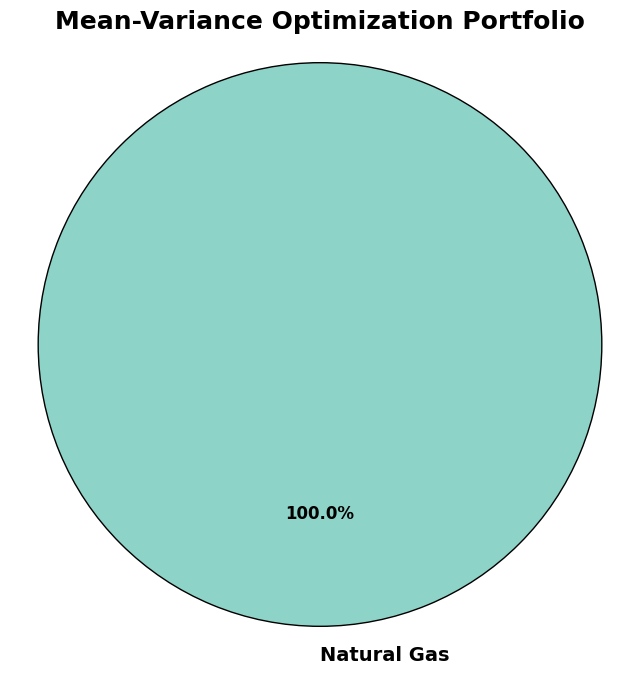

In [90]:
risk_tolerance = 0.01  # Set risk tolerance (gamma)
mean_variance_weights = mean_variance_optimization(
    COMMODITIES, cov_matrix, mean_returns, risk_tolerance
)
plot_pie_chart(mean_variance_weights, "Mean-Variance Optimization Portfolio")

### Risk Parity Optimization

Gurobi 12.0.1: Set parameter LogToConsole to value 1
  tech:outlev = 1

AMPL MP initial flat model has 5 variables (0 integer, 0 binary);
Objectives: 1 quadratic; 
Constraints:  1 linear;

AMPL MP final model has 5 variables (0 integer, 0 binary);
Objectives: 1 quadratic; 
Constraints:  1 linear;


Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
InfUnbdInfo  1

Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0xfcd63839
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 5 columns, 5 nonzeros
Presolve

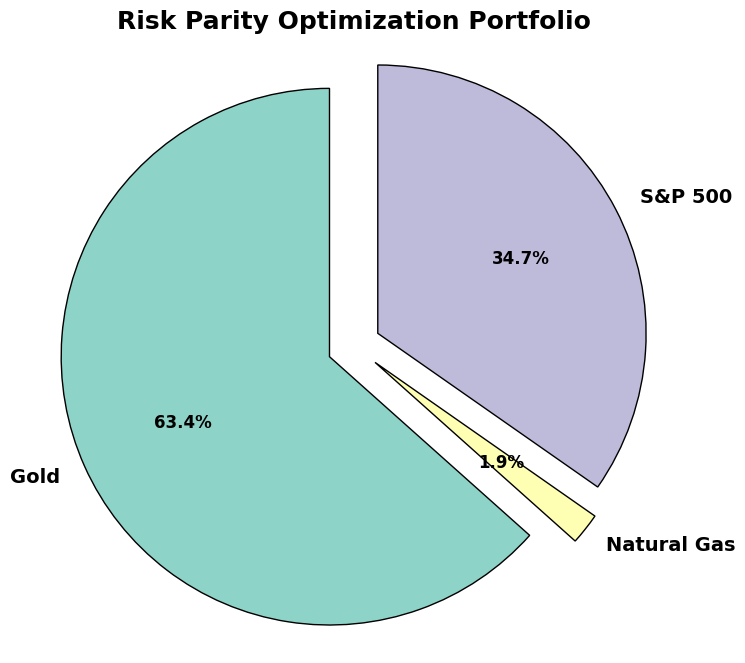

In [91]:
total_volatility = np.sqrt(np.dot(mean_returns, np.dot(cov_matrix, mean_returns)))
risk_parity_weights = risk_parity_optimization(
    COMMODITIES, cov_matrix, total_volatility
)
plot_pie_chart(risk_parity_weights, "Risk Parity Optimization Portfolio")

### Max Sharpe Optimization

Gurobi 12.0.1: Set parameter LogToConsole to value 1
  tech:outlev = 1

AMPL MP initial flat model has 5 variables (0 integer, 0 binary);
Objectives: 1 linear; 
Constraints:  2 linear; 1 quadratic;
Algebraic expressions:  1 div; 1 powconstexp;

AMPL MP final model has 9 variables (0 integer, 0 binary);
Objectives: 1 linear; 
Constraints:  2 linear; 1 quadratic;
Algebraic expressions:  1 div; 1 powconstexp;


Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
InfUnbdInfo  1

Optimize a model with 1 rows, 9 columns and 5 nonzeros
Model fingerprint: 0x2dd5ab5a
Model has 1 general nonlinear constraint (17 nonlinear terms)
Variable types: 9 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [

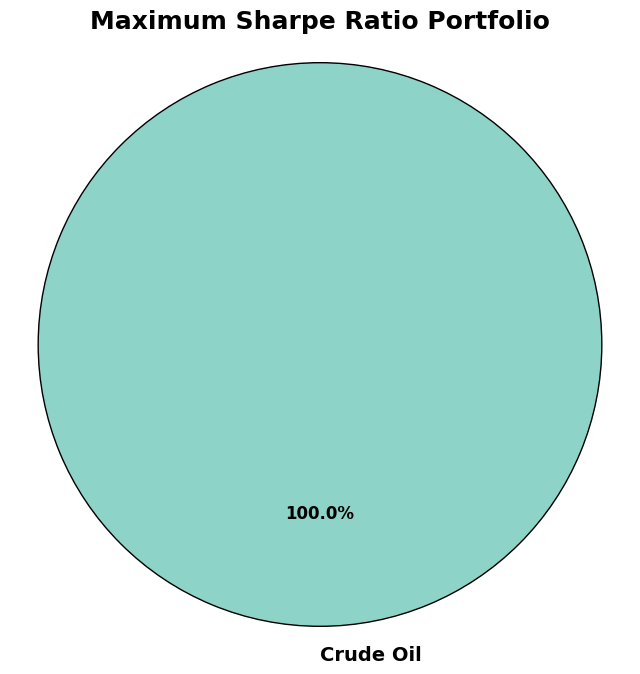

In [92]:
# Maximum Sharpe Ratio Optimization
max_sharpe_weights = max_sharpe_optimization(COMMODITIES, cov_matrix, mean_returns)
plot_pie_chart(max_sharpe_weights, "Maximum Sharpe Ratio Portfolio")